In [42]:
import pandas as pd 
import numpy as np

import sys

In [43]:
blood_data = pd.read_csv("./data/Blood_data_Tema.csv")

In [44]:
blood_data.isna().sum()

YEAR             0
MONTH            0
QTY_DEMANDED    13
QTY_SUPPLIED     9
dtype: int64

In [45]:
blood_data_without_na = blood_data.fillna({"QTY_DEMANDED": 0, "QTY_SUPPLIED": 0})  # Replace NaNs with 0

In [46]:
blood_data_without_na.isna().sum()

YEAR            0
MONTH           0
QTY_DEMANDED    0
QTY_SUPPLIED    0
dtype: int64

In [47]:
blood_data_without_na.head()

,YEAR,MONTH,QTY_DEMANDED,QTY_SUPPLIED
0,2013,January,162.0,136.0
1,2013,February,188.0,202.0
2,2013,March,229.0,225.0
3,2013,April,220.0,204.0
4,2013,May,252.0,251.0


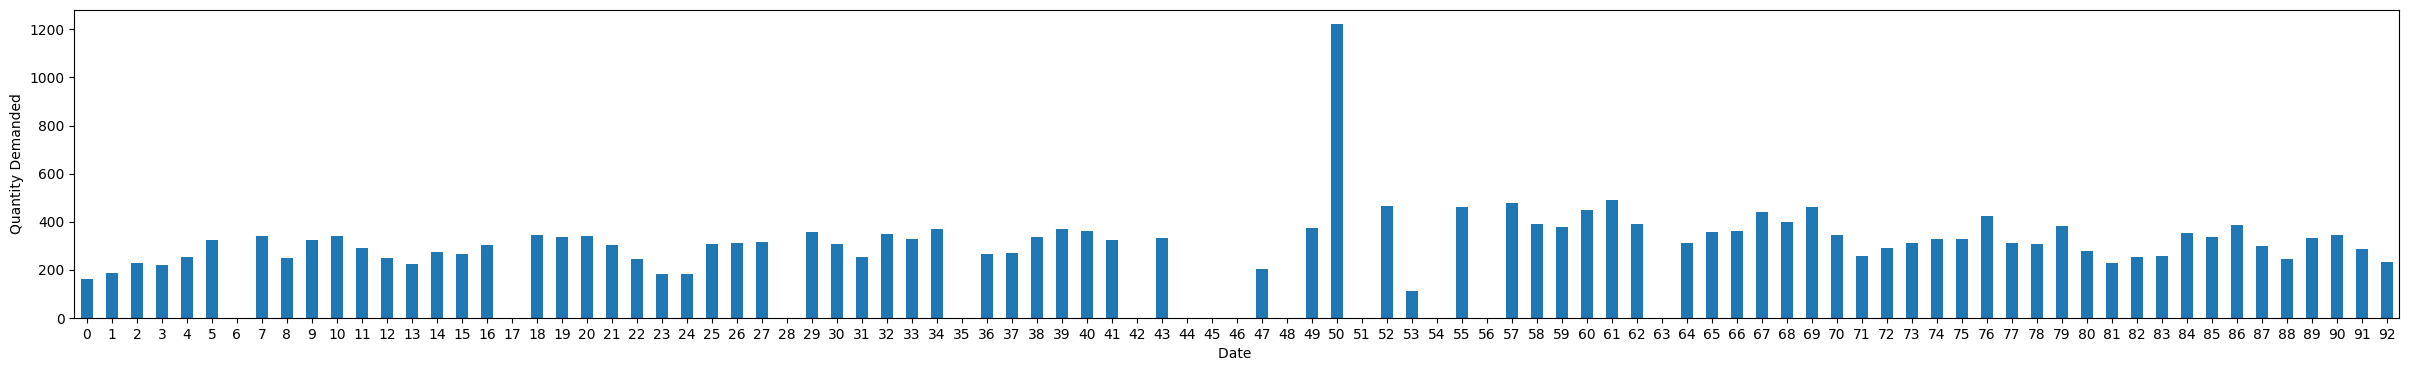

In [48]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(figsize=(30, 4))

blood_data_without_na['QTY_DEMANDED'].plot(kind='bar', rot=0, ax=axs)

plt.xlabel("Date ");  # custom x label using Matplotlib

plt.ylabel("Quantity Demanded");

In [49]:
years = blood_data_without_na["YEAR"].unique().tolist()
months = blood_data_without_na["MONTH"].unique().tolist()

In [50]:
years

[2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020]

In [51]:
months

['January',
 'February',
 'March',
 'April',
 'May',
 'June',
 'July',
 'August',
 'September',
 'October',
 'November',
 'December']

In [52]:
blood_data_yearly = blood_data_without_na.groupby("YEAR")[["QTY_DEMANDED", "QTY_SUPPLIED"]].sum().reset_index()

In [53]:
blood_data_yearly

,YEAR,QTY_DEMANDED,QTY_SUPPLIED
0,2013,2918.0,2791.0
1,2014,3067.0,3699.0
2,2015,3071.0,4684.0
3,2016,2457.0,5286.0
4,2017,3872.0,5717.0
5,2018,4257.0,4999.0
6,2019,3696.0,6017.0
7,2020,2815.0,3778.0


array([[<Axes: title={'center': 'YEAR'}>,
        <Axes: title={'center': 'QTY_DEMANDED'}>],
       [<Axes: title={'center': 'QTY_SUPPLIED'}>, <Axes: >]], dtype=object)

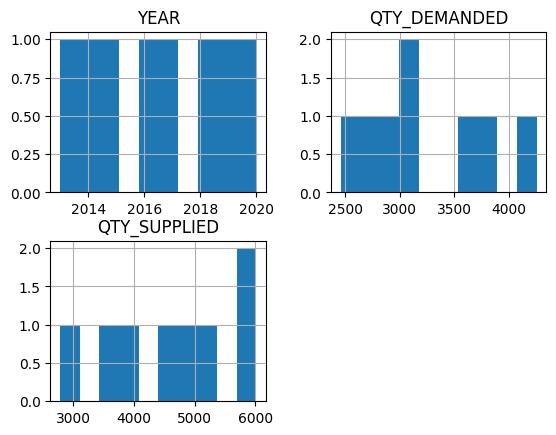

In [54]:
blood_data_yearly.hist()

## Scaling the data

In [55]:
from sklearn.preprocessing import MinMaxScaler


year_scaler = MinMaxScaler()
month_scaler = MinMaxScaler()

scaled_blood_data_yearly = blood_data_yearly.copy()
scaled_blood_data_monthly = blood_data_without_na.copy()

scaled_blood_data_yearly[["QTY_DEMANDED","QTY_SUPPLIED"]] = year_scaler.fit_transform(blood_data_yearly[["QTY_DEMANDED","QTY_SUPPLIED"]])
scaled_blood_data_monthly[["QTY_DEMANDED","QTY_SUPPLIED"]] = month_scaler.fit_transform(blood_data_without_na[["QTY_DEMANDED","QTY_SUPPLIED"]])

In [56]:
scaled_blood_data_yearly

,YEAR,QTY_DEMANDED,QTY_SUPPLIED
0,2013,0.256111,0.000000
1,2014,0.338889,0.281463
2,2015,0.341111,0.586795
3,2016,0.000000,0.773404
4,2017,0.786111,0.907006
5,2018,1.000000,0.684439
6,2019,0.688333,1.000000
7,2020,0.198889,0.305952


## Creating the model

In [57]:
import tensorflow as tf 
import keras

from keras.layers import LSTM, Input, Dropout, Embedding, Dense, add
from keras import Model
from keras.utils import plot_model

In [58]:
# model parameters

N_INPUT_YEARS = 4
N_INPUT_MONTHS = 6

DROP_OUT_RATE = 0.2

BATCH_SIZE = 16
N_EPOCHS = 15


In [59]:

def get_model():
    year_input_layer = Input(shape=((N_INPUT_YEARS,1 )))
    year_lstm_layer = LSTM(128, name="year_lstm")(year_input_layer)
    year_fc_1 = Dense(256)(year_lstm_layer)
    year_dropout = Dropout(DROP_OUT_RATE)(year_fc_1)
    year_fc_2 = Dense(500)(year_dropout)
    
    month_input_layer = Input(shape=((N_INPUT_MONTHS, 1)))
    month_lstm_layer = LSTM(128, name="month_lstm")(month_input_layer)
    month_fc_1 = Dense(256)(month_lstm_layer)
    month_dropout = Dropout(DROP_OUT_RATE)(month_fc_1)
    month_fc_2 = Dense(500)(month_dropout)
    
    combine = add([year_fc_2, month_fc_2])
    dense_decoder = Dense(256, activation='relu')(combine)

    output = Dense(1, activation="sigmoid")(dense_decoder)

    return Model(inputs=[year_input_layer, month_input_layer], outputs=output)


In [60]:
model = get_model()

plot_model(model, to_file="model.png", show_shapes=True, show_layer_names=True)


You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [61]:
opt = keras.optimizers.Adam(learning_rate=1e-3)
model.compile(optimizer=opt, loss="mse", metrics=["mae"])

In [62]:
def data_generator(batch_size=16, batch_size_year: int = 4, batch_size_month: int = 6):
    len_scaled_blood_data_yearly = len(scaled_blood_data_yearly)
    start_year = scaled_blood_data_yearly.loc[0, "YEAR"]
    while True:
        yr_inputs, mth_inputs, outputs = [], [], []
        sample = 0
        
        for i in range(1, len_scaled_blood_data_yearly - batch_size_year - 1):
            current_year = scaled_blood_data_yearly.loc[i, "YEAR"]
            next_year_data = scaled_blood_data_monthly[scaled_blood_data_monthly["YEAR"] == current_year + 1]
    
            year_input_data = scaled_blood_data_yearly.loc[i: i+batch_size_year - 1, "QTY_DEMANDED"]
    
            for j in range(12):
                month_input_data = scaled_blood_data_monthly.loc[(current_year - start_year) * 12 + j + 1 - batch_size_month : (current_year - start_year) * 12 + j, "QTY_DEMANDED"]
                to_predict = scaled_blood_data_monthly.loc[(current_year - start_year) * 12 + j + 1, "QTY_DEMANDED"]
                
                yr_inputs.append(year_input_data.values)
                mth_inputs.append(month_input_data.values)
                outputs.append(to_predict)
                sample += 1
    
    
                if sample >= batch_size:
                    sample = 0
                    yield ([np.array(yr_inputs), np.array(mth_inputs)], np.array(outputs))
                    
                    yr_inputs, mth_inputs, outputs = [], [], []
    
                    

In [63]:
default_data_generator = data_generator(batch_size=16)

steps_per_epoch = 50

history = model.fit(
        default_data_generator, 
        epochs=N_EPOCHS, 
        steps_per_epoch=steps_per_epoch, 
        verbose=1,
)

Epoch 1/15
50/50 [==============================] - 11s 17ms/step - loss: 0.0126 - mae: 0.0853
Epoch 2/15
50/50 [==============================] - 1s 20ms/step - loss: 0.0069 - mae: 0.0640
Epoch 3/15
50/50 [==============================] - 1s 20ms/step - loss: 0.0063 - mae: 0.0587
Epoch 4/15
50/50 [==============================] - 1s 21ms/step - loss: 0.0056 - mae: 0.0542
Epoch 5/15
50/50 [==============================] - 1s 20ms/step - loss: 0.0055 - mae: 0.0531
Epoch 6/15
50/50 [==============================] - 1s 21ms/step - loss: 0.0052 - mae: 0.0515
Epoch 7/15
50/50 [==============================] - 1s 20ms/step - loss: 0.0053 - mae: 0.0516
Epoch 8/15
50/50 [==============================] - 1s 18ms/step - loss: 0.0050 - mae: 0.0501
Epoch 9/15
50/50 [==============================] - 1s 20ms/step - loss: 0.0046 - mae: 0.0476
Epoch 10/15
50/50 [==============================] - 1s 17ms/step - loss: 0.0036 - mae: 0.0436
Epoch 11/15
50/50 [==============================] - 1s 20

In [64]:
year_inputs = year_scaler.transform([[1000,0],[3000,0], [2000,0], [1500,0]])
months_inputs = month_scaler.transform([[100,0],[200,0], [150,0], [250,0], [300,0], [100,0]])


predictions = model.predict([np.array(year_inputs[:, 0]).reshape(1, N_INPUT_YEARS), np.array(months_inputs[:, 0]).reshape(1, N_INPUT_MONTHS)])

predictions


C:\Users\prash\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\prash\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 2s 2s/step


array([[0.44905728]], dtype=float32)

In [65]:
month_scaler.get_feature_names_out()

array(['QTY_DEMANDED', 'QTY_SUPPLIED'], dtype=object)

In [66]:
# Add a dummy feature (zeros)
dummy_feature = np.zeros((predictions.shape[0], 1))
predictions_with_dummy = np.hstack([dummy_feature, predictions])

# Transform using the scaler
transformed = month_scaler.inverse_transform(predictions_with_dummy)

# Extract only the transformed feature
transformed_predictions = transformed[0, :]

print(transformed_predictions)

[  0.         431.54404706]


In [68]:
model.save("./models/demand_model.keras")